# Gerando novos personagens com uma DCGAN

.

Este _notebook_ é parte do trabalho [pixel sides](pixel-sides.ipynb). Ele descreve um experimento de criação de 
uma **rede generativa adversarial convolucional profunda** (DCGAN) para **gerar novas imagens de personagens**
em _pixel art_ dado o conjunto de dados TinyHero.

In [103]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [104]:
SEED = 42

DATA_FOLDER = "tiny-hero"
POSE_FOLDER_NAMES = ["0-back", "1-left", "2-front", "3-right"]

IMAGE_SIZE = 64
CHANNELS = 4

BUFFER_SIZE = 3648
BATCH_SIZE = 128

NOISE_SIZE = 100

## Carregando o _dataset_

Criando o _dataset_ a partir das imagens nos diretórios especificados acima:

In [105]:
X = np.ndarray(shape=(0, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
for i, folder in enumerate(POSE_FOLDER_NAMES):
    filelist = glob.glob(os.path.join(DATA_FOLDER, folder, "*.png"))
    x = np.array([np.array(PIL.Image.open(fname)) for fname in filelist])
    X = np.concatenate((X, x))
    y = np.full((X.shape[0],), i)
print(X.shape)
print(y.shape)
X = X.reshape(X.shape[0], IMAGE_SIZE, IMAGE_SIZE, CHANNELS).astype('float32')
X = (X - 127.5) / 127.5


X = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(3648, 64, 64, 4)
(3648,)


In [106]:
def denormalize_image(image):
    return (image + 1) / 2

def show_image(image):
    plt.imshow(image, interpolation="nearest")
    
def show_normalized_image(image):
    show_image(denormalize_image(image))

## Gerador

A rede geradora foi criada como uma sequência de 3 "deconvoluções" com normalização em _batch_ para auxiliar com
a possibilidade de problemas de _vanishing gradients_ e ativação com _LeakyReLU_. Ele recebe um vetor de ruído com
100 valores entre $\{-1, +1\}$ sorteados com distribuição normal centralizada em $0$.

A ativação da última camada usa tangente hiperbólica para gerar números entre $\{-1, +1\}$.

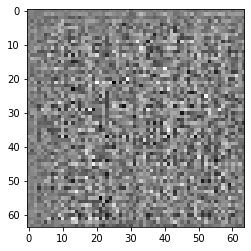

In [107]:
def make_generator_model():
    return tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(NOISE_SIZE,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Reshape((8, 8, 256)),
        
        layers.Conv2DTranspose(128, 5, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False),        
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
    ], name="Gerador")



generator = make_generator_model()
# print(generator.summary())

noise = tf.random.normal([1, NOISE_SIZE])
sample_generated_image = generator(noise, training=False)

plt.imshow(sample_generated_image[0, :, :, 0], cmap="gray")

# noise = tf.random.normal([1, NOISE_SIZE], seed=SEED)
# sample_generated_image = generator(noise, training=False)

# show_normalized_image(sample_generated_image[0])


## Discriminador

A rede discriminadora é uma rede neural convolucional com 2 sequências de camadas de convolução e _max pooling_ e uma final totalmente conectada.
A ativação usada também é _LeakyReLU_ e para regularização foi usada a técnica _dropout_ com probabilidades baixas.

In [108]:
def build_discriminator():
    return tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding="same", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 4)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, 5, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(1)
    ], name="Discriminador")

discriminator = build_discriminator()
print(discriminator.summary())

decision = discriminator(sample_generated_image)
print(decision)

Model: "Discriminador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 64)        6464      
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_72 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 32768)           

## Treinamento

In [109]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.999)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


A seguir, algumas configurações do treinamento e avaliação:

In [110]:
EPOCHS = 250
EXAMPLES_TO_PREVIEW = 16


In [111]:
preview_generated_noise = tf.random.normal([EXAMPLES_TO_PREVIEW, NOISE_SIZE])



@tf.function
def gan_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_SIZE], seed=SEED)
    
    with tf.GradientTape() as generator_steps, tf.GradientTape() as discriminator_steps:
        # gera as imagens
        generated_images = generator(noise, training=True)

        # discriminador tenta classificar reais e geradas
        real_images_output = discriminator(images, training=True)
        fake_images_output = discriminator(generated_images, training=True)
 
        # cálculo dos erros
        generator_error = generator_loss(fake_images_output)
        discriminator_error = discriminator_loss(real_images_output, fake_images_output)

        
    # atualização de pesos
    generator_gradients = generator_steps.gradient(generator_error, generator.trainable_variables)
    discriminator_gradients = discriminator_steps.gradient(discriminator_error, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return generator_error, discriminator_error
    
    

In [112]:
from functools import reduce
import operator

def gan_train(dataset, epochs):
    generator_errors = []
    discriminator_errors = []

    for epoch in range(epochs):
        print("Iniciando época ", epoch)
        
        batch_generator_errors = []
        batch_discriminator_errors = []
        for batch in dataset:
            gen_error, dis_error = gan_train_step(batch)
            batch_generator_errors.append(gen_error)
            batch_discriminator_errors.append(dis_error)
        generator_errors.append(reduce(operator.add, batch_generator_errors) / len(batch_generator_errors))
        discriminator_errors.append(reduce(operator.add, batch_discriminator_errors) / len(batch_discriminator_errors))
        
        display.clear_output(wait=True)
        
        generate_and_save_images(generator, epoch+1, preview_generated_noise)
    
    return generator_errors, discriminator_errors

In [113]:
def generate_and_save_images(model, epoch, test_input):
    amount = test_input.shape[0]
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(int(amount**0.5), int(amount**0.5), i+1)
        show_normalized_image(predictions[i])
        plt.axis("off")

    plt.savefig("temp_new_sprite/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()
    

Dá início ao treinamento:

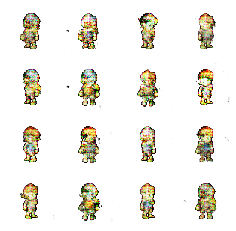

In [114]:
from io_utils import ensure_folder_structure, delete_folder
delete_folder("temp_new_sprite")
ensure_folder_structure("temp_new_sprite")

generator_errors, discriminator_errors = gan_train(X, EPOCHS)

Mostra o erro do discriminador e do gerador ao longo das épocas:

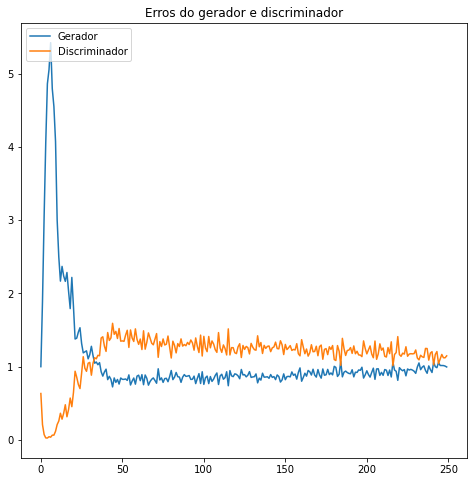

In [115]:
epochs_batches_range = range(len(generator_errors))

plt.figure(figsize=(8, 8))
plt.plot(epochs_batches_range, generator_errors, label="Gerador")
plt.plot(epochs_batches_range, discriminator_errors, label="Discriminador")
plt.legend(loc="upper left")
plt.title("Erros do gerador e discriminador")
plt.show()

Exibe algumas imagens e gera uma animação ao longo das épocas:

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('temp_new_sprite/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

anim_file = 'dcgan.gif'

import imageio
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('temp_new_sprite/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename, pilmode="RGBA")
        alpha = image[:,:,3]
        image[alpha < 100] = (255, 255, 255, 0)
        alpha[alpha >= 100] = 255
        writer.append_data(image)
    image = imageio.imread(filename)
    alpha = image[:,:,3]
    image[alpha < 100] = (255, 255, 255, 0)
    alpha[alpha >= 100] = 255
    writer.append_data(image)

from IPython.display import Image
Image(open(anim_file, "rb").read())

![center](docs/images/dcgan.gif)